In [1]:
import h5py
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import sys
import shutil
import glob
import optparse
import os
import json
import cPickle as pkl
import pandas as pd
import numpy as np
import pylab as pl
import scipy.stats as stats
import seaborn as sns
sys.path.append('/n/coxfs01/cechavarria/repos/2p-pipeline/')
from pipeline.python.paradigm import utils as util

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in 

In [2]:
class struct: pass

opts = struct()
opts.rootdir = '/n/coxfs01/2p-data'
opts.animalid = 'JC080'
opts.session = '20190619'
opts.acquisition = 'FOV1_zoom4p0x'
opts.traceid = 'traces001'
opts.combined_run = 'scenes_combined'

In [3]:
traceid = '%s_s2p'%(opts.traceid)
#% Set up paths:    
acquisition_dir = os.path.join(opts.rootdir, opts.animalid, opts.session, opts.acquisition)
traceid_dir = os.path.join(acquisition_dir, opts.combined_run,'traces',traceid)

run_dir = traceid_dir.split('/traces')[0]
trace_arrays_dir = os.path.join(traceid_dir,'files')
paradigm_dir = os.path.join(acquisition_dir, opts.combined_run, 'paradigm')

In [8]:
#read trace file file
parsedtraces_filepath = glob.glob(os.path.join(traceid_dir, 'files','parsedtraces*'))[0]
file_grp = h5py.File(parsedtraces_filepath, 'r')

curr_slice = 'Slice01'#hard-code planar data for now
pix_cell_array = np.array(file_grp[curr_slice]['traces']['np_subtracted'])
ntrials,ntpts,nrois = pix_cell_array.shape

if 's2p_cell_rois' in file_grp.attrs.keys():
    cell_rois = file_grp.attrs['s2p_cell_rois']
else:
    cell_rois = np.arange(nrois)



pre_frames = file_grp.attrs['pre_frames']
post_frames = file_grp.attrs['post_frames']
stim_frames = file_grp.attrs['stim_frames']
#to get baseline index with [0:pre_frames]
#to get stim period do [pre_frames:pre_frames+stim_frames+1]


frames_tsec = np.array(file_grp[curr_slice]['frames_tsec'])
#get raw pixel value arrays




file_grp.close()

In [9]:
#get file with trial-by-trial responses
responses_dir = os.path.join(acquisition_dir, opts.combined_run,'responses',traceid)
data_array_dir = os.path.join(responses_dir, 'data_arrays')

resp_array_fn = 'trial_response_array.hdf5'
resp_array_filepath = os.path.join(data_array_dir,'files' , resp_array_fn)
resp_grp = h5py.File(resp_array_filepath, 'r')


curr_slice = 'Slice01'#hard,coding for now

#unpack
filter_crit_matrix_trials = np.array(resp_grp['/'.join([curr_slice, 'responses' ,'zscore'])])

resp_grp.close()


filter_crit_matrix_mean = np.squeeze(np.mean(filter_crit_matrix_trials,0))

#consider a config active if at least one of theversion of an image evoked a response above threshol
thresh = 1
thresh_matrix = filter_crit_matrix_mean>thresh
filter_matrix = np.zeros((thresh_matrix.shape))
for ridx in range(nrois):
    for idx in range(0,thresh_matrix.shape[0],3):
            if np.sum(thresh_matrix[idx:idx+3,ridx])>0:
                filter_matrix[idx:idx+3,ridx] = 1



#load trial info
stimconfig_fn = 'trial_conditions.hdf5'
stimconfig_filepath = os.path.join(paradigm_dir, 'files', stimconfig_fn)
config_grp = h5py.File(stimconfig_filepath, 'r')

trial_config = np.array(config_grp['trial_config'])
trial_cond = np.array(config_grp['trial_cond'])
trial_img = np.array(config_grp['trial_img'])

config_grp.close()

In [10]:
num_active_rois = np.sum(np.sum(filter_matrix,0)>0)
frac_active_rois = num_active_rois/float(len(cell_rois))
print('# active rois = %i'%(num_active_rois))
print('frac active rois = %.04f'%(frac_active_rois))

# active rois = 78
frac active rois = 0.4875


In [11]:
#for each roi, first average across trials per config, then normalize across configs
#-should result in higher values, also noticed bigger differences in values

nconfigs = len(np.unique(trial_config))
print('ROIs:%i'%(nrois))
print('Trials:%i'%(ntrials))


norm_roi_df_array = np.empty((ntpts,nconfigs,nrois))
norm_array_filt = np.ones((norm_roi_df_array.shape))*np.nan
config_cond = np.empty((nconfigs,))
config_img = np.empty((nconfigs,))

for ridx in range(nrois):
#ridx = 0
    roi_df_array = np.empty((ntrials,ntpts))
    for tidx in range(ntrials):

        #get trial timecourse
        pix_cell = np.squeeze(pix_cell_array[tidx,:,ridx].squeeze())

        #get baseline
        base_cell = pix_cell[0:pre_frames]

        #calculate df
        df_cell = pix_cell - np.mean(base_cell)

        #store in array
        roi_df_array[tidx,:] = df_cell


    mean_df_array = np.empty((nconfigs,ntpts))
    for cfg_idx in np.unique(trial_config):


        cfg_key = 'config%03d'%(cfg_idx)
        tidx = np.where(trial_config == cfg_idx)[0]
        config_cond[int(cfg_idx)] = trial_cond[tidx][0]
        config_img[int(cfg_idx)] = trial_img[tidx][0]

        mean_df_array[int(cfg_idx),:] = np.nanmean(roi_df_array[tidx,:],0)

    #normalize traces across configs
    norm_roi_df_array[:,:,ridx] = np.transpose(mean_df_array/np.nanmax(mean_df_array.flatten()))
    
    #filter out traces to unresponsive conditions within neuron
    for cfg_idx in np.unique(trial_config):
        cfg_idx = int(cfg_idx)
        if filter_matrix[cfg_idx,ridx]:
            norm_array_filt[:,cfg_idx,ridx] = norm_roi_df_array[:,cfg_idx,ridx]

ROIs:208
Trials:1500


In [37]:
active_rois_per_config = np.sum(filter_matrix,1)
active_rois_per_config = np.expand_dims(active_rois_per_config,1)
active_rois_per_config_tile = np.matmul(np.ones((ntpts,1)),np.transpose(active_rois_per_config))


In [25]:
#old 
filtered_trace_mean = np.zeros((ntpts,nconfigs))
filtered_trace_se = np.zeros((ntpts,nconfigs))
active_rois_per_config = np.zeros((nconfigs,))
pass_config = np.zeros((nconfigs,))

for cfg_idx in np.unique(trial_config):
    cfg_idx = int(cfg_idx)
    #cfg_idx = 45
    pass_ridxs = np.where(filter_matrix[cfg_idx,:])[0]
    #consider only cell indices
    pass_ridxs = np.array(list((set(cell_rois)&set(pass_ridxs))))
    active_rois_per_config[cfg_idx] = pass_ridxs.size
    if pass_ridxs.size>0:
        pass_config[cfg_idx] = 1
        filtered_trace_mean[:,cfg_idx] = np.nanmean(norm_roi_df_array[:,cfg_idx,pass_ridxs],1)
        filtered_trace_se[:,cfg_idx] = np.nanstd(norm_roi_df_array[:,cfg_idx,pass_ridxs],1)/pass_ridxs.size

In [26]:
fig_out_dir = os.path.join(traceid_dir,'figures','filtered_traces')
if not os.path.exists(fig_out_dir):
    os.makedirs(fig_out_dir)

In [27]:
#put things into pandas df for plotting
meandfs = []
ylabel = 'Normalized Response'
#cfg_key = 'config001'
for cfg_count in range(nconfigs):
    cfg_key = 'config%03d'%(cfg_count)
    img = config_img[cfg_count]+1
    stim_cond = config_cond[cfg_count]
    mean_trace = filtered_trace_mean[:,cfg_count]
    sem_trace = filtered_trace_se[:,cfg_count]
    nreps = active_rois_per_config[cfg_count]
    mdf = pd.DataFrame({'%s' % ylabel: mean_trace,
                        'tsec': frames_tsec,
                        'sem': sem_trace,
                       'fill_minus': mean_trace - sem_trace,
                        'fill_plus': mean_trace + sem_trace,
                        'config': [cfg_count for _ in range(len(mean_trace))],
                        'img' : [img for _ in range(len(mean_trace))],
                        'stim_cond' : [stim_cond for _ in range(len(mean_trace))],
                       'nreps': [nreps for _ in range(len(mean_trace))]
                       })

    meandfs.append(mdf)
meandfs = pd.concat(meandfs, axis=0)

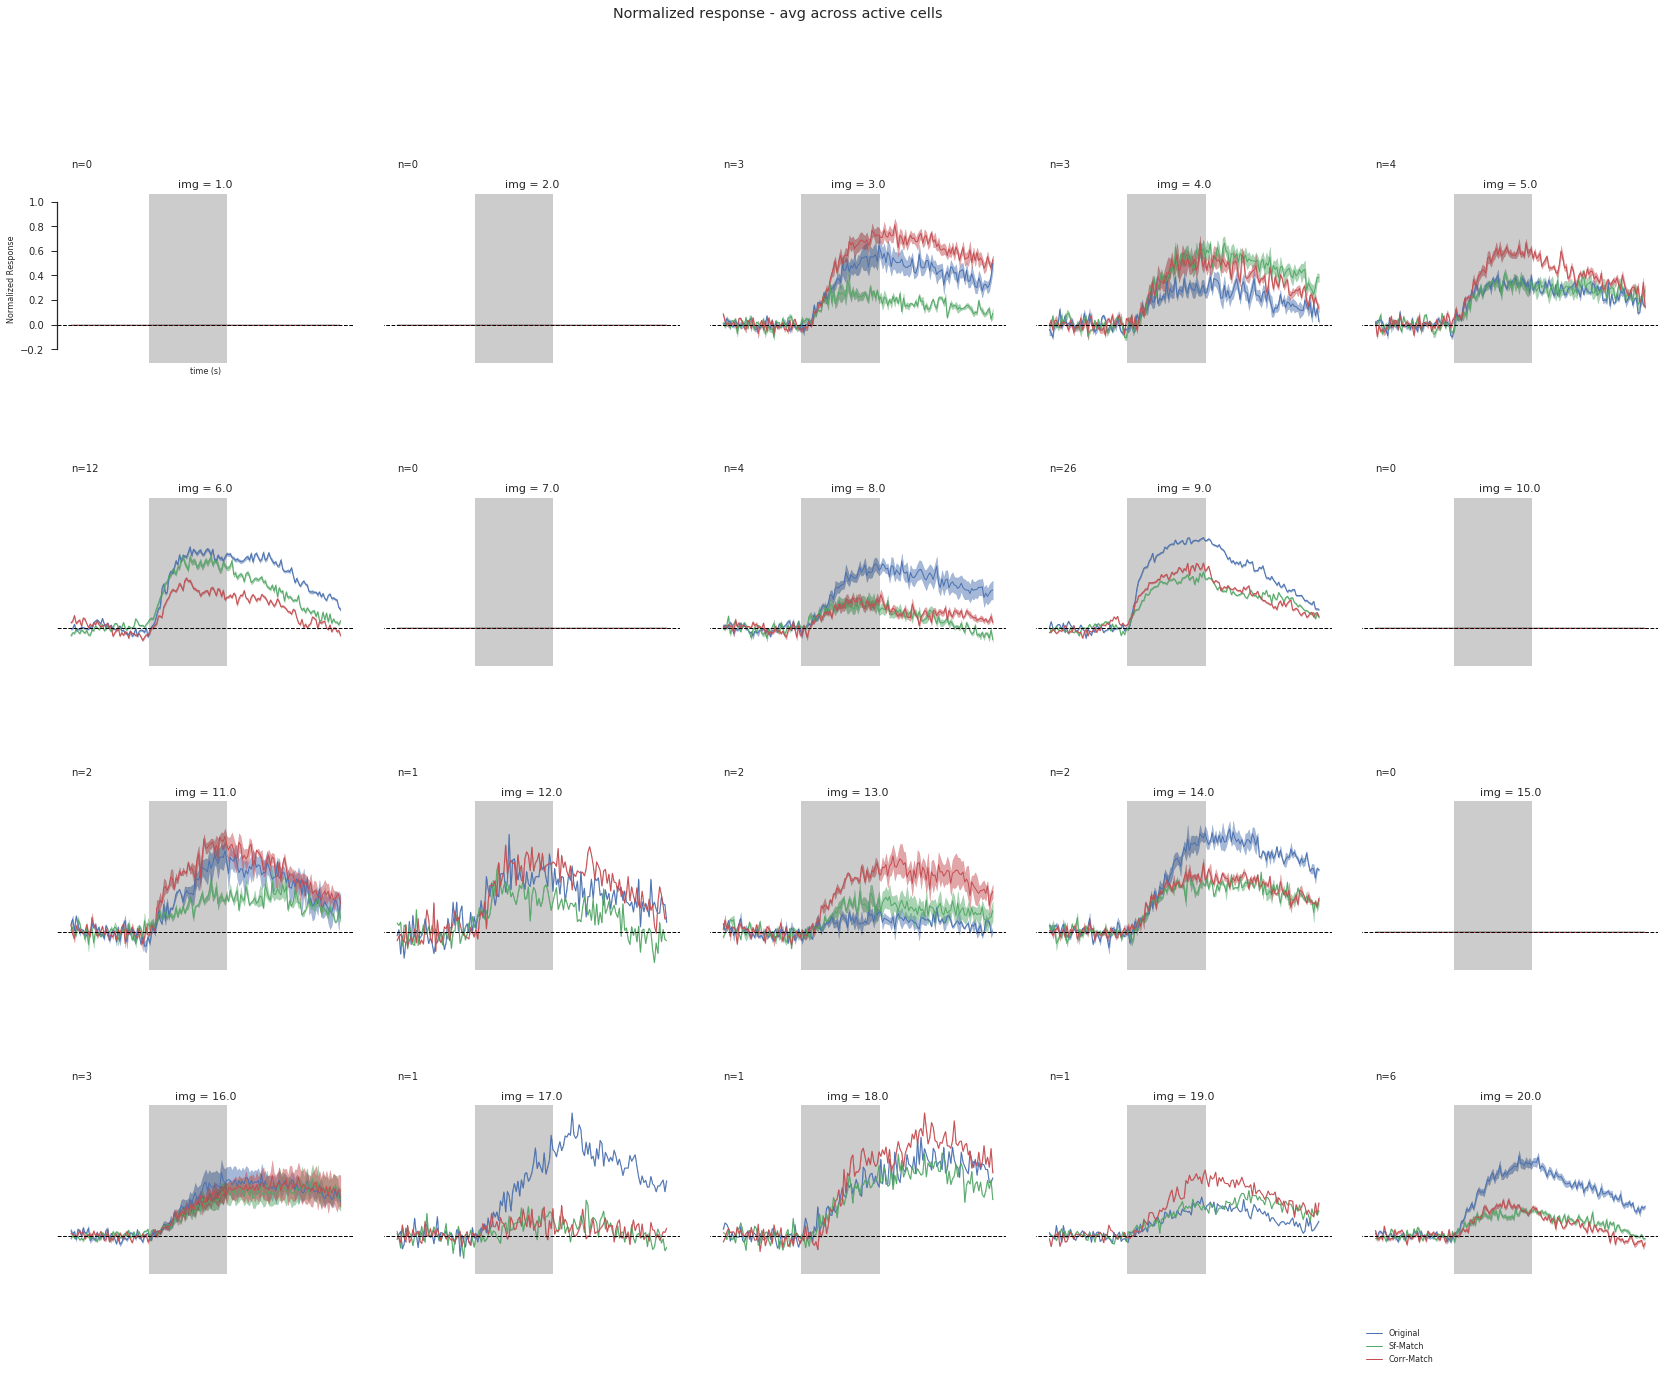

In [28]:
psth_cols = 5
sns.set_style("ticks")
trace_labels = ['Original','Sf-Match','Corr-Match']
fig_title = ('Normalized response - avg across active cells')
fig_fn = 'filtered_trace_avg_active_rois_old.png'
fig_file_path = os.path.join(fig_out_dir,fig_fn)

#make figure
p = sns.FacetGrid(meandfs, col="img", col_wrap=psth_cols, hue='stim_cond', size=5)
p = p.map(pl.fill_between, "tsec", "fill_minus", "fill_plus", alpha=0.5)
p = p.map(pl.plot, "tsec", ylabel, lw=1, alpha=1)
pl.subplots_adjust(wspace=0.1, hspace=0.8, top=0.85, bottom=0.1, left=0.1)

axes = p.axes
ymin,ymax = axes[0].get_ylim()
xmin,xmax = axes[0].get_xlim()
start_val = 0.0
end_val = 1.0 #hard-coding
for ri in range(p.axes.shape[0]):
        #print ri, ci
        p.axes[ri].add_patch(patches.Rectangle((start_val, ymin), end_val, ymax-ymin, linewidth=0, fill=True, color='k', alpha=0.2))
        p.axes[ri].text(-0.999, ymax+(ymax*0.2), 'n=%i' % active_rois_per_config[ri*3], fontsize=10)
        p.axes[ri].axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '--')

        if ri == 0:
          #  p.axes[ri].yaxis.set_major_locator(pl.MaxNLocator(2))
            p.axes[ri].set_xticks(())
            sns.despine(trim=True, offset=0, bottom=True, left=False, ax=p.axes[ri])
            p.axes[ri].set_xlabel('time (s)', fontsize=8)
            p.axes[ri].set_ylabel('%s' % ylabel, fontsize=8)
        else:
            sns.despine(trim=True, offset=0, bottom=True, left=True, ax=p.axes[ri])
            p.axes[ri].tick_params(
                                    axis='both',          # changes apply to the x-axis
                                    which='both',      # both major and minor ticks are affected
                                    bottom='off',      # ticks along the bottom edge are off
                                    left='off',
                                    top='off',         # ticks along the top edge are off
                                    labelbottom='off',
                                    labelleft='off') # labels along the bottom edge are off)
            p.axes[ri].set_xlabel('')
            p.axes[ri].set_ylabel('')
pl.legend(bbox_to_anchor=(0, -0.3), loc=2, borderaxespad=0.1, labels=trace_labels, fontsize=8)

p.fig.suptitle(fig_title)
p.savefig(fig_file_path)

In [59]:
# active_config = active_rois_per_config>0
# filtered_trace_cond_mean = np.zeros((ntpts,3))
# filtered_traces_tmp = np.array([])
# for cfg_idx in range(0,nconfigs,3):
#     if active_config[cfg_idx]:
#         if filtered_traces_tmp.size ==0:
#             filtered_traces_tmp = filtered_trace_mean[:,cfg_idx:cfg_idx+3]
#             print(filtered_traces_tmp.shape)
#         else:
#             filtered_traces_tmp = np.dstack((filtered_traces_tmp ,filtered_trace_mean[:,cfg_idx:cfg_idx+3]))

(155, 3)


In [29]:
filtered_trace_cond_mean = np.zeros((ntpts,3))
filtered_traces_tmp = np.array([])
for cfg_idx in range(0,nconfigs,3):
    if pass_config[cfg_idx]:
        if filtered_traces_tmp.size ==0:
            filtered_traces_tmp = filtered_trace_mean[:,cfg_idx:cfg_idx+3]
            print(filtered_traces_tmp.shape)
        else:
            filtered_traces_tmp = np.dstack((filtered_traces_tmp ,filtered_trace_mean[:,cfg_idx:cfg_idx+3]))

(155, 3)


In [30]:
n_active_images = filtered_traces_tmp.shape[2]
filtered_trace_cond_mean = np.nanmean(filtered_traces_tmp,2)
filtered_trace_cond_se = np.nanstd(filtered_traces_tmp,2)/n_active_images

In [31]:
#put things into pandas df for plotting
conddfs = []
ylabel = 'Normalized Response'
#cfg_key = 'config001'
for cond_count in range(filtered_trace_cond_mean.shape[1]):
    stim_cond = cond_count
    mean_trace = filtered_trace_cond_mean[:,cond_count]
    sem_trace = filtered_trace_cond_se[:,cond_count]
    nreps = n_active_images
    cdf = pd.DataFrame({'%s' % ylabel: mean_trace,
                        'tsec': frames_tsec,
                        'sem': sem_trace,
                       'fill_minus': mean_trace - sem_trace,
                        'fill_plus': mean_trace + sem_trace,
                        'config': [cfg_count for _ in range(len(mean_trace))],
                        'img' : [img for _ in range(len(mean_trace))],
                        'stim_cond' : [stim_cond for _ in range(len(mean_trace))],
                       'nreps': [nreps for _ in range(len(mean_trace))]
                       })

    conddfs.append(cdf)
conddfs = pd.concat(conddfs, axis=0)

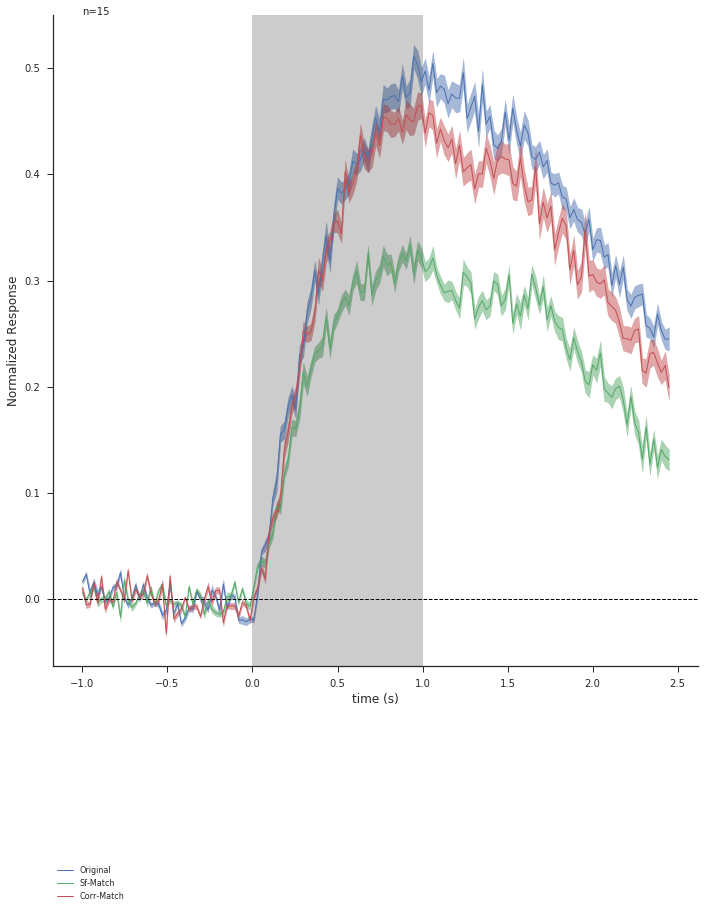

In [32]:
fig_title = ('Normalized response - avg across active images')
fig_fn = 'filtered_trace_avg_across_active_images_old.png'
fig_file_path = os.path.join(fig_out_dir,fig_fn)

#make figure
p = sns.FacetGrid(conddfs, hue='stim_cond', size=10)
p = p.map(pl.fill_between, "tsec", "fill_minus", "fill_plus", alpha=0.5)
p = p.map(pl.plot, "tsec", ylabel, lw=1, alpha=1)


axes = p.ax
ymin,ymax = axes.get_ylim()
xmin,xmax = axes.get_xlim()
start_val = 0.0
end_val = 1.0 #hard-coding

        #print ri, ci
p.ax.add_patch(patches.Rectangle((start_val, ymin), end_val, ymax-ymin, linewidth=0, fill=True, color='k', alpha=0.2))
p.ax.text(-0.999, ymax+(ymax*0), 'n=%i' % n_active_images, fontsize=10)
p.ax.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '--')


#p.ax.set_xticks(())
#sns.despine(trim=True, offset=0, bottom=True, left=False, ax=p.ax)
p.ax.set_xlabel('time (s)', fontsize=12)
p.ax.set_ylabel('%s' % ylabel, fontsize=12)


pl.legend(bbox_to_anchor=(0, -0.3), loc=2, borderaxespad=0.1, labels=trace_labels, fontsize=8)


p.savefig(fig_file_path)

In [224]:
#averaging across active configs first

In [230]:
filtered_trace_cond_roi_mean = np.zeros((ntpts,3,nrois))


for cidx in range(3):
#cidx = 0
    for ridx in range(nrois):
        #ridx = 0
        pass_cidxs = np.where(filter_matrix[:,ridx])[0]
        cond_config = np.where(config_cond==cidx)[0]
        pass_cidxs = np.array(list((set(cond_config)&set(pass_cidxs))))
        if pass_cidxs.size>0:
            filtered_trace_cond_roi_mean[:,cidx,ridx] = np.nanmean(norm_roi_df_array[:,pass_cidxs,ridx],1)


In [231]:
active_rois = np.sum(filter_matrix,0)>0

#consider only cell indices
active_cells = np.array(list( set(cell_rois) & set(np.where(active_rois)[0])))

In [232]:
filtered_trace_cond_mean2 = np.nanmean(filtered_trace_cond_roi_mean[:,:,active_cells],2)
filtered_trace_cond_se2 = np.nanstd(filtered_trace_cond_roi_mean[:,:,active_cells],2)/len(active_cells)

In [233]:
#put things into pandas df for plotting
conddfs2 = []
ylabel = 'Normalized Response'
#cfg_key = 'config001'
for cond_count in range(filtered_trace_cond_mean2.shape[1]):
    stim_cond = cond_count
    mean_trace = filtered_trace_cond_mean2[:,cond_count]
    sem_trace = filtered_trace_cond_se2[:,cond_count]
    nreps = active_cells
    cdf = pd.DataFrame({'%s' % ylabel: mean_trace,
                        'tsec': frames_tsec,
                        'sem': sem_trace,
                       'fill_minus': mean_trace - sem_trace,
                        'fill_plus': mean_trace + sem_trace,
                        'config': [cfg_count for _ in range(len(mean_trace))],
                        'img' : [img for _ in range(len(mean_trace))],
                        'stim_cond' : [stim_cond for _ in range(len(mean_trace))],
                       'nreps': [nreps for _ in range(len(mean_trace))]
                       })

    conddfs2.append(cdf)
conddfs2 = pd.concat(conddfs2, axis=0)

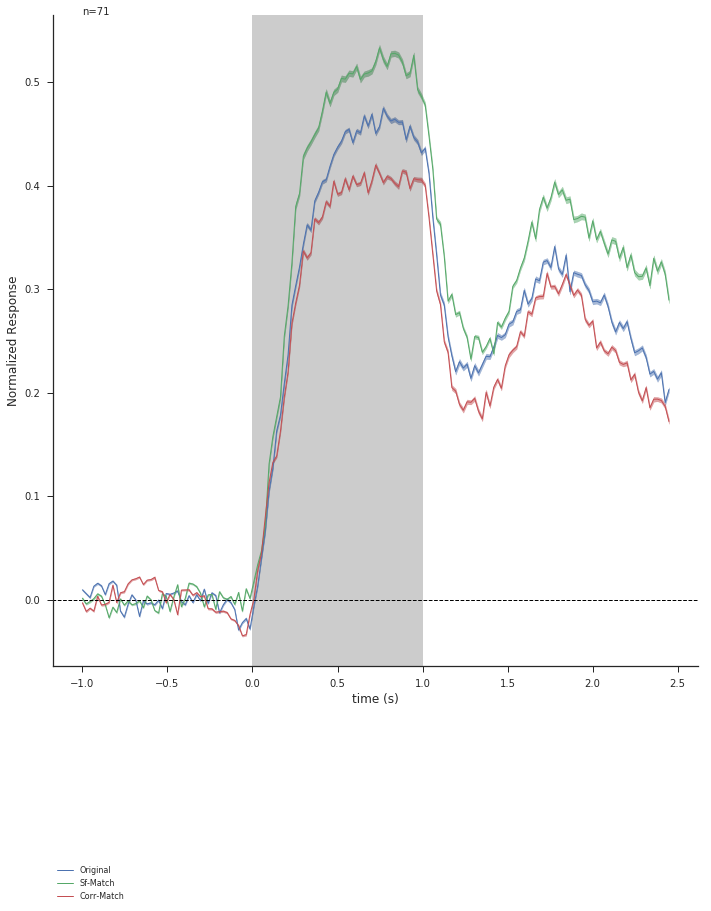

In [235]:
fig_title = ('Normalized response - avg across active images')
fig_fn = 'filtered_trace_avg_across_active_images.png'
fig_file_path = os.path.join(fig_out_dir,fig_fn)

#make figure
p = sns.FacetGrid(conddfs2, hue='stim_cond', size=10)
p = p.map(pl.fill_between, "tsec", "fill_minus", "fill_plus", alpha=0.5)
p = p.map(pl.plot, "tsec", ylabel, lw=1, alpha=1)


axes = p.ax
ymin,ymax = axes.get_ylim()
xmin,xmax = axes.get_xlim()
start_val = 0.0
end_val = 1.0 #hard-coding

        #print ri, ci
p.ax.add_patch(patches.Rectangle((start_val, ymin), end_val, ymax-ymin, linewidth=0, fill=True, color='k', alpha=0.2))
p.ax.text(-0.999, ymax+(ymax*0), 'n=%i' % len(active_cells), fontsize=10)
p.ax.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '--')


#p.ax.set_xticks(())
#sns.despine(trim=True, offset=0, bottom=True, left=False, ax=p.ax)
p.ax.set_xlabel('time (s)', fontsize=12)
p.ax.set_ylabel('%s' % ylabel, fontsize=12)


pl.legend(bbox_to_anchor=(0, -0.3), loc=2, borderaxespad=0.1, labels=trace_labels, fontsize=8)


#p.savefig(fig_file_path)

In [ ]:
 
for cfg_idx in np.unique(trial_config):
    cfg_idx = int(cfg_idx)
    #cfg_idx = 45
    pass_ridxs = np.where(filter_matrix[cfg_idx,:])[0]
    #consider only cell indices
    pass_ridxs = np.array(list((set(cell_rois)&set(pass_ridxs))))
    pass_rois[cfg_idx] = pass_ridxs.size
    if pass_ridxs.size>0:
        pass_config[cfg_idx] = 1
        filtered_trace_mean[:,cfg_idx] = np.nanmean(norm_roi_df_array[:,cfg_idx,pass_ridxs],1)
        filtered_trace_se[:,cfg_idx] = np.nanstd(norm_roi_df_array[:,cfg_idx,pass_ridxs],1)/pass_ridxs.size

In [ ]:
norm_roi_df_array

In [ ]:
plt.plot()

In [ ]:
roi_df_array.shape

In [ ]:
#----Junk Code below here------

In [ ]:
#open timecourse file to read
data_array_fn = 'processed_config_traces.hdf5'
data_array_filepath = os.path.join(traceid_dir, 'data_arrays', data_array_fn)
data_grp = h5py.File(data_array_filepath, 'r')

frames_tsec = data_grp.attrs['frames_tsec']
nrois = data_grp.attrs['nrois']
print('ROIs:%i'%(nrois))

if 's2p_cell_rois' in data_grp.attrs.keys():
    cell_rois = data_grp.attrs['s2p_cell_rois']
else:
    cell_rois = np.arange(nrois)

curr_slice = 'Slice01'#hard,coding for now

In [ ]:
trace_type = 'df_f'

In [ ]:
data_type = 'np_subtracted'

In [ ]:

for cfg_count,cfg_key in enumerate(data_grp[curr_slice].keys()):
    # cfg_count = 0
    # cfg_key = 'config000'

    #find rois responsive to this condition
    ridxs = np.where(filter_matrix[cfg_count,:])[0]

    if cfg_count == 0:
        filtered_trace_mean = np.zeros((np.array(data_grp['/'.join([curr_slice,cfg_key,trace_type, 'trace_mean',data_type])]).shape[0],len(data_grp[curr_slice].keys())))
        filtered_trace_se = np.zeros((np.array(data_grp['/'.join([curr_slice,cfg_key,trace_type, 'trace_mean',data_type])]).shape[0],len(data_grp[curr_slice].keys())))
    if ridxs.size>0:
        trace_array = np.empty((np.array(data_grp['/'.join([curr_slice,cfg_key,trace_type, 'trace_mean',data_type])]).shape[0],ridxs.size))
        for ridx_count, ridx in enumerate(ridxs):
            #consider only cells ROIS!! <- To Do
            trace_array[:,ridx_count] = np.array(data_grp['/'.join([curr_slice,cfg_key,trace_type, 'trace_mean',data_type])])[:,ridx]
    #take average and store in array
    filtered_trace_mean[:,cfg_count] = np.mean(trace_array,1)
    filtered_trace_se[:,cfg_count] = stats.sem(trace_array,1)

In [ ]:
filtered_trace_mean[:,2]